In [65]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [66]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

df = pd.read_csv("flour_dataset.csv")

In [67]:
pid = 'Package ID'
gluten = 'Gluten Content (%)'
elasticity = 'Dough Elasticity Index'
dampening = 'Dampening Time (hours)'
weight = 'Package Weight (g)'
ash = 'Ash content (%)'
recipe = 'Production Recipe'
moisture = 'Moisture (%)'
starch = 'Starch Content (%)'
mill = 'Production Mill'
volume = 'Package Volume (cm3)'
proteins = 'Proteins (g)/100g'
color = 'Color'
quality = 'Quality'
unnamed = 'Unnamed: 14'

In [68]:
def clean_df(df):
    df_filtered = df[df.isnull().sum(1) == 1].drop(columns=[unnamed])
    outliers = (df_filtered[ash] > 10) | (df_filtered[dampening] < 0) | (df_filtered[elasticity] > 200) | (df_filtered[gluten] < 0)
    df_good = df_filtered[~outliers]
    return df_good

df = clean_df(df)

In [80]:
def stack_dict(inputs):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))

    return tf.stack(values, axis=-1)

def sanitize_name(f):
    return "".join(x for x in f if x.isalnum())
    
def get_model(name, df, **kwargs):
    categorical_string_names = [
        'Production Mill',
    ]
    categorical_int_names = [
        'Production Recipe',
    ]

    numeric_feature_names = [
        #'Package ID',
        'Gluten Content (%)',
        'Dough Elasticity Index',
        'Dampening Time (hours)',
        'Package Weight (g)',
        'Ash content (%)',
        'Moisture (%)',
        'Starch Content (%)',
        'Package Volume (cm3)',
        'Proteins (g)/100g',
        'Color',
    ]
    if 'simple' in name:
        numeric_feature_names.remove('Package Volume (cm3)')
    if 'with_id' in name:
        numeric_feature_names.append('Package ID')
    if 'no_cat' in name:
        categorical_string_names.remove('Production Mill')
        categorical_int_names.remove('Production Recipe')
    categorical_feature_names = categorical_string_names + categorical_int_names

    numeric_features = df[numeric_feature_names]
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(stack_dict(dict(numeric_features)))

    inputs = {}
    for fname in df.keys():
        if fname in categorical_string_names:
            dtype = tf.string
            inputs[fname] = tf.keras.Input(shape=[], name=sanitize_name(fname), dtype=dtype)
        elif fname in categorical_int_names:
            dtype = tf.int64
            inputs[fname] = tf.keras.Input(shape=(), name=sanitize_name(fname), dtype=dtype)
        elif fname in numeric_feature_names:
            dtype = tf.float32
            inputs[fname] = tf.keras.Input(shape=(), name=sanitize_name(fname), dtype=dtype)
        else:
            print(f"Will ignore feature {fname}")
            continue

    numeric_inputs = {}
    for fname in numeric_feature_names:
        numeric_inputs[fname] = inputs[fname]
    
    numeric_inputs = stack_dict(numeric_inputs)
    numeric_normalized = normalizer(numeric_inputs)
    
    preprocessed = []
    preprocessed.append(numeric_normalized)

    for fname in categorical_feature_names:
        vocab = sorted(set(df[fname]))
        if type(vocab[0]) is str:
            lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
        else:
            lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

        x = inputs[fname][:, tf.newaxis]
        x = lookup(x)
        preprocessed.append(x)

    preprocessed_result = tf.concat(preprocessed, axis=-1)
    preprocessor = tf.keras.Model(inputs, preprocessed_result)
    
    x = preprocessor(inputs)

    n_input = len(numeric_feature_names)+len(categorical_feature_names)
    hidden = tf.keras.layers.Dense(n_input, activation='relu')(x)
    dropout = kwargs.pop('dropout',False)
    deep    = kwargs.pop('deep',False)
    if dropout:
        hidden = tf.keras.layers.Dropout(.2, input_shape=(n_input,))(hidden)
    if deep:
        hidden = tf.keras.layers.Dense(n_input*2, activation='relu', **kwargs)(hidden)
        if dropout:
            hidden = tf.keras.layers.Dropout(.5, input_shape=(n_input*2,))(hidden)
        hidden = tf.keras.layers.Dense(n_input, activation='relu', **kwargs)(hidden)

    out1 = tf.keras.layers.Dense(1, activation='sigmoid', name='low_vs_avghigh')(hidden)
    out2 = tf.keras.layers.Dense(1, activation='sigmoid', name='lowavg_vs_high')(hidden)
        
    losses = {
        'low_vs_avghigh':'binary_crossentropy',
        'lowavg_vs_high':'binary_crossentropy',
             }

    model = tf.keras.Model(inputs=inputs, outputs=[out1, out2], name=name)
    model.compile(optimizer='adam',
                loss=losses,
                metrics=['accuracy'])
    model.summary()
    return model

model = get_model('test', df)

2022-11-30 02:50:47.726950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 02:50:47.743810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Quality
Model: "test"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  [(N

In [70]:
def train_model(name, model, df, y, **kwargs):
    
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(patience=20, mode="min", restore_best_weights=True)) #, monitor="val_loss"))
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(f"checkpoints_{name}", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=True,))
    # Terminate on NaN such that it is easier to debug
    callbacks.append(tf.keras.callbacks.TerminateOnNaN())
    
    opts = {'epochs':50, 'batch_size':32}
    opts.update(kwargs)

    history = model.fit(df, y, callbacks=callbacks, **opts)
    model.save(Path(name) / 'model')

    return history

def get_labels(df):
    target = df['Quality']
    target_names = ['Low','Average','High'] #set manually to keep this order
    target_labels = tf.keras.layers.StringLookup(vocabulary=target_names, output_mode='int')
    y = target_labels(target)-1
    y1 = tf.math.minimum(y,tf.constant([1], dtype=tf.int64))   #merge Avg+High
    y2 = tf.math.maximum(y,tf.constant([1], dtype=tf.int64))-1 #merge Low+Avg
    return [y1, y2]

def labels_to_class(y):
    y = tf.stack(y,axis=1)
    return tf.math.reduce_sum(y,axis=1)
    

In [71]:
from sklearn.model_selection import train_test_split

def resample_high(df, n):
    df_high = pd.concat([df[df['Quality']=='High']] * n)
    df = pd.concat([df,df_high ])
    return df


train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df = resample_high(train_df,20)

train_y = get_labels(train_df)
test_y  = get_labels(test_df)

#class_weights = {(0,0):1/39, (0,1):1/59, (1,1):1/2}

history = train_model('test', model, dict(train_df), train_y, 
                      validation_data=(dict(test_df), test_y),
                     )
                      #class_weight=class_weights)

Epoch 1/50


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 02:34:15.002011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.6066 - low_vs_avghigh_loss: 0.8449 - lowavg_vs_high_loss: 0.7618 - low_vs_avghigh_accuracy: 0.4597 - lowavg_vs_high_accuracy: 0.5335

2022-11-30 02:34:16.105199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 2s 27ms/step - loss: 1.6066 - low_vs_avghigh_loss: 0.8449 - lowavg_vs_high_loss: 0.7618 - low_vs_avghigh_accuracy: 0.4597 - lowavg_vs_high_accuracy: 0.5335 - val_loss: 1.4705 - val_low_vs_avghigh_loss: 0.8166 - val_lowavg_vs_high_loss: 0.6539 - val_low_vs_avghigh_accuracy: 0.4825 - val_lowavg_vs_high_accuracy: 0.6189
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4330 - low_vs_avghigh_loss: 0.7825 - lowavg_vs_high_loss: 0.6505 - low_vs_avghigh_accuracy: 0.5068 - lowavg_vs_high_accuracy: 0.6250 - val_loss: 1.3013 - val_low_vs_avghigh_loss: 0.7695 - val_lowavg_vs_high_loss: 0.5318 - val_low_vs_avghigh_accuracy: 0.5245 - val_lowavg_vs_high_accuracy: 0.7587
Epoch 3/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3112 - low_vs_avghigh_loss: 0.7277 - lowavg_vs_high_loss: 0.5835 - low_vs_avghigh_accuracy: 0.5724 - lowavg_vs_high_accuracy: 0.6872 - val_loss: 1.1714 - val_low_vs_avghigh_loss: 0.7280 - val_lo

46/46 [==============================] - 1s 12ms/step - loss: 0.6066 - low_vs_avghigh_loss: 0.3798 - lowavg_vs_high_loss: 0.2267 - low_vs_avghigh_accuracy: 0.8559 - lowavg_vs_high_accuracy: 0.8900 - val_loss: 0.5242 - val_low_vs_avghigh_loss: 0.4009 - val_lowavg_vs_high_loss: 0.1233 - val_low_vs_avghigh_accuracy: 0.8322 - val_lowavg_vs_high_accuracy: 0.9825
Epoch 24/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5965 - low_vs_avghigh_loss: 0.3773 - lowavg_vs_high_loss: 0.2191 - low_vs_avghigh_accuracy: 0.8566 - lowavg_vs_high_accuracy: 0.8941 - val_loss: 0.5177 - val_low_vs_avghigh_loss: 0.3969 - val_lowavg_vs_high_loss: 0.1208 - val_low_vs_avghigh_accuracy: 0.8322 - val_lowavg_vs_high_accuracy: 0.9825
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5870 - low_vs_avghigh_loss: 0.3744 - lowavg_vs_high_loss: 0.2126 - low_vs_avghigh_accuracy: 0.8552 - lowavg_vs_high_accuracy: 0.8921 - val_loss: 0.5187 - val_low_vs_avghigh_loss: 0.3975 - val_

46/46 [==============================] - 1s 11ms/step - loss: 0.4672 - low_vs_avghigh_loss: 0.3415 - lowavg_vs_high_loss: 0.1257 - low_vs_avghigh_accuracy: 0.8627 - lowavg_vs_high_accuracy: 0.9501 - val_loss: 0.4805 - val_low_vs_avghigh_loss: 0.3829 - val_lowavg_vs_high_loss: 0.0976 - val_low_vs_avghigh_accuracy: 0.8182 - val_lowavg_vs_high_accuracy: 0.9755
Epoch 46/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4626 - low_vs_avghigh_loss: 0.3401 - lowavg_vs_high_loss: 0.1225 - low_vs_avghigh_accuracy: 0.8613 - lowavg_vs_high_accuracy: 0.9611 - val_loss: 0.4794 - val_low_vs_avghigh_loss: 0.3821 - val_lowavg_vs_high_loss: 0.0972 - val_low_vs_avghigh_accuracy: 0.8147 - val_lowavg_vs_high_accuracy: 0.9755
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4590 - low_vs_avghigh_loss: 0.3393 - lowavg_vs_high_loss: 0.1197 - low_vs_avghigh_accuracy: 0.8627 - lowavg_vs_high_accuracy: 0.9617 - val_loss: 0.4769 - val_low_vs_avghigh_loss: 0.3810 - val_

INFO:tensorflow:Assets written to: test/model/assets


INFO:tensorflow:Assets written to: test/model/assets


In [90]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay as CMD

def validation_plots(name, history, model, test_df):

    plt.figure()
    plt.plot(history.history['low_vs_avghigh_loss'], label=f'train low vs avg+high')
    plt.plot(history.history['val_low_vs_avghigh_loss'], label=f'test low vs avg+high')
    plt.plot(history.history['lowavg_vs_high_loss'], label=f'train low+avg vs high')
    plt.plot(history.history['val_lowavg_vs_high_loss'], label=f'test low+avg vs high')

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.suptitle(name)

    plt.legend()
    plt.ylim([0,0.9])
    plt.savefig(Path(name) / 'losses.png')
    plt.show()
    plt.close()
    
    plt.figure()
    #plt.plot(tf.multiply(history.history['lowavg_vs_high_accuracy'],history.history['low_vs_avghigh_accuracy']), label=f'train both')
    #plt.plot(tf.multiply(history.history['val_lowavg_vs_high_accuracy'],history.history['val_low_vs_avghigh_accuracy']), label=f'test both')
    plt.plot(history.history['low_vs_avghigh_accuracy'], label=f'train low vs avg+high')
    plt.plot(history.history['val_low_vs_avghigh_accuracy'], label=f'test low vs avg+high')
    plt.plot(history.history['lowavg_vs_high_accuracy'], label=f'train low+avg vs high')
    plt.plot(history.history['val_lowavg_vs_high_accuracy'], label=f'test low+avg vs high')

    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.suptitle(name)

    plt.legend()
    plt.ylim([0,1.1])
    plt.savefig(Path(name) / 'accuracy.png')
    plt.show()
    plt.close()
    
    test_p = model(dict(test_df))
    predicted_class = tf.squeeze(tf.cast(test_p[0] > 0.5, tf.int64) +  tf.cast(test_p[1] > 0.5, tf.int64))
    is_sure = tf.squeeze((test_p[0] < 0.25) | (test_p[0] > 0.75))

    test_y = get_labels(test_df)
    test_class = labels_to_class(test_y)

    print("Average fraction of mistakes:",name, (test_class!=predicted_class).numpy().mean())
    print("Average fraction of sure decisions:",name, is_sure.numpy().mean())
    print("Average fraction of mistakes on sure decisions:",name, (test_class!=predicted_class)[is_sure].numpy().mean())
    plt.figure()
    plt.suptitle(name)
    cm = CMD.from_predictions(test_class, predicted_class)
    cm.plot()
    plt.savefig(Path(name) / 'confusion_matrix.png')
    plt.close()
    
    bins=np.linspace(0,1,10)
    fig, (ax0,ax1) = plt.subplots(2,1, figsize=(5,6))
    fig.suptitle(name)

    ax0.hist(test_p[0][test_class==0].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='Low, NN-low-vs-rest')
    ax0.hist(test_p[0][test_class==1].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='Avg, NN-low-vs-rest')
    ax0.hist(test_p[0][test_class==2].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='High, NN-low-vs-rest')
    ax1.hist(test_p[1][test_class==0].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='Low, NN-high-vs-rest')
    ax1.hist(test_p[1][test_class==1].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='Avg, NN-high-vs-rest')
    ax1.hist(test_p[1][test_class==2].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='High, NN-high-vs-rest')
    
    ax0.legend()
    ax0.set_ylim([0,140])
    ax1.legend()
    ax1.set_ylim([0,160])
    plt.savefig(Path(name) / 'NN_output.png')
    plt.show()
    plt.close()

2022-11-30 02:50:51.325820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 02:50:51.339352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Production Recipe
Will ignore feature Production Mill
Will ignore feature Quality
Model: "massive_no_cat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                   

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Production Recipe', 'Production Mill', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 02:50:51.918194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.5123 - low_vs_avghigh_loss: 0.6910 - lowavg_vs_high_loss: 0.8214 - low_vs_avghigh_accuracy: 0.5628 - lowavg_vs_high_accuracy: 0.4898

2022-11-30 02:50:54.628652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 4s 57ms/step - loss: 1.5123 - low_vs_avghigh_loss: 0.6910 - lowavg_vs_high_loss: 0.8214 - low_vs_avghigh_accuracy: 0.5628 - lowavg_vs_high_accuracy: 0.4898 - val_loss: 1.2371 - val_low_vs_avghigh_loss: 0.6540 - val_lowavg_vs_high_loss: 0.5831 - val_low_vs_avghigh_accuracy: 0.5909 - val_lowavg_vs_high_accuracy: 0.8951
Epoch 2/200
46/46 [==============================] - 1s 16ms/step - loss: 1.3564 - low_vs_avghigh_loss: 0.6848 - lowavg_vs_high_loss: 0.6716 - low_vs_avghigh_accuracy: 0.5567 - lowavg_vs_high_accuracy: 0.6510 - val_loss: 1.1537 - val_low_vs_avghigh_loss: 0.6516 - val_lowavg_vs_high_loss: 0.5022 - val_low_vs_avghigh_accuracy: 0.6713 - val_lowavg_vs_high_accuracy: 0.9755
Epoch 3/200
46/46 [==============================] - 1s 15ms/step - loss: 1.2773 - low_vs_avghigh_loss: 0.6570 - lowavg_vs_high_loss: 0.6203 - low_vs_avghigh_accuracy: 0.6352 - lowavg_vs_high_accuracy: 0.7063 - val_loss: 1.0886 - val_low_vs_avghigh_loss: 0.6324 - val_

46/46 [==============================] - 1s 11ms/step - loss: 0.8765 - low_vs_avghigh_loss: 0.4418 - lowavg_vs_high_loss: 0.4347 - low_vs_avghigh_accuracy: 0.8142 - lowavg_vs_high_accuracy: 0.7705 - val_loss: 0.6673 - val_low_vs_avghigh_loss: 0.3954 - val_lowavg_vs_high_loss: 0.2720 - val_low_vs_avghigh_accuracy: 0.8357 - val_lowavg_vs_high_accuracy: 0.9790
Epoch 24/200
46/46 [==============================] - 1s 11ms/step - loss: 0.8609 - low_vs_avghigh_loss: 0.4283 - lowavg_vs_high_loss: 0.4326 - low_vs_avghigh_accuracy: 0.8265 - lowavg_vs_high_accuracy: 0.7725 - val_loss: 0.6642 - val_low_vs_avghigh_loss: 0.3870 - val_lowavg_vs_high_loss: 0.2772 - val_low_vs_avghigh_accuracy: 0.8427 - val_lowavg_vs_high_accuracy: 0.9790
Epoch 25/200
46/46 [==============================] - 1s 12ms/step - loss: 0.8672 - low_vs_avghigh_loss: 0.4438 - lowavg_vs_high_loss: 0.4234 - low_vs_avghigh_accuracy: 0.8067 - lowavg_vs_high_accuracy: 0.7719 - val_loss: 0.6621 - val_low_vs_avghigh_loss: 0.3855 - va

Epoch 45/200
46/46 [==============================] - 1s 11ms/step - loss: 0.7083 - low_vs_avghigh_loss: 0.4099 - lowavg_vs_high_loss: 0.2984 - low_vs_avghigh_accuracy: 0.8306 - lowavg_vs_high_accuracy: 0.8730 - val_loss: 0.6389 - val_low_vs_avghigh_loss: 0.3865 - val_lowavg_vs_high_loss: 0.2524 - val_low_vs_avghigh_accuracy: 0.8636 - val_lowavg_vs_high_accuracy: 0.9161
Epoch 46/200
46/46 [==============================] - 1s 11ms/step - loss: 0.6939 - low_vs_avghigh_loss: 0.4046 - lowavg_vs_high_loss: 0.2893 - low_vs_avghigh_accuracy: 0.8292 - lowavg_vs_high_accuracy: 0.8784 - val_loss: 0.6362 - val_low_vs_avghigh_loss: 0.3896 - val_lowavg_vs_high_loss: 0.2466 - val_low_vs_avghigh_accuracy: 0.8636 - val_lowavg_vs_high_accuracy: 0.9231
Epoch 47/200
46/46 [==============================] - 1s 11ms/step - loss: 0.6676 - low_vs_avghigh_loss: 0.3867 - lowavg_vs_high_loss: 0.2809 - low_vs_avghigh_accuracy: 0.8456 - lowavg_vs_high_accuracy: 0.8832 - val_loss: 0.6700 - val_low_vs_avghigh_loss

INFO:tensorflow:Assets written to: massive_no_cat/model/assets


INFO:tensorflow:Assets written to: massive_no_cat/model/assets


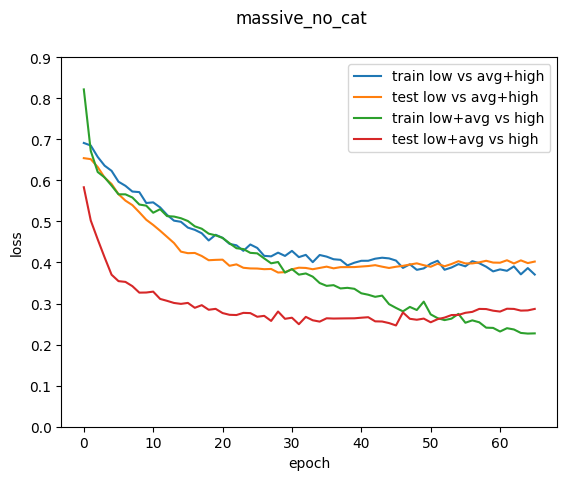

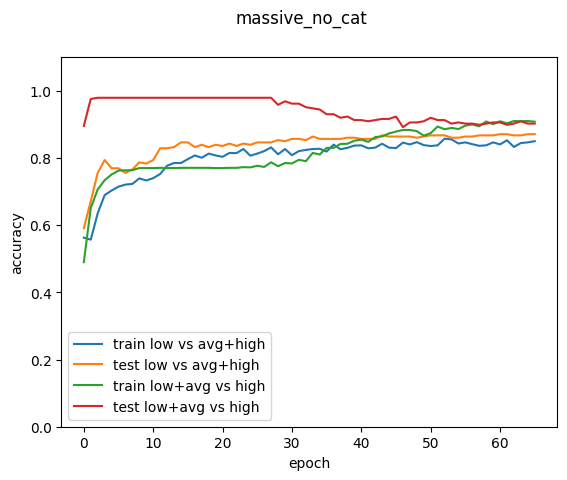

Average fraction of mistakes: massive_no_cat 0.1993006993006993


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Production Recipe', 'Production Mill', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

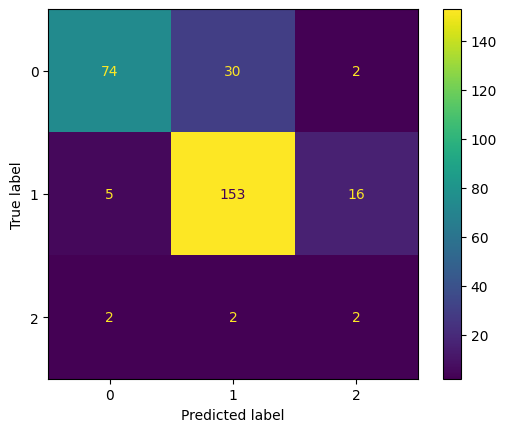

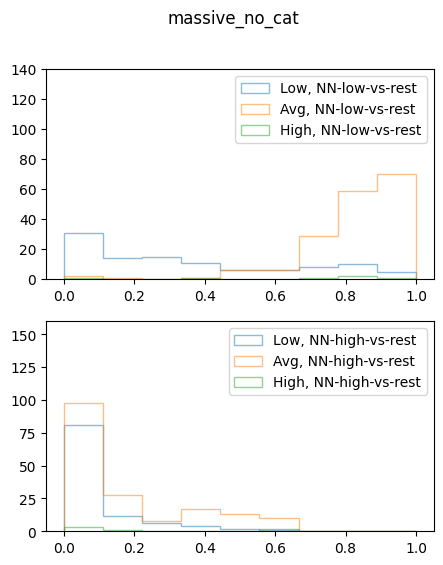

2022-11-30 02:51:33.155570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 02:51:33.170052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Quality
Model: "massive_sum"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputL

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 02:51:34.081798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.3852 - low_vs_avghigh_loss: 0.7142 - lowavg_vs_high_loss: 0.6710 - low_vs_avghigh_accuracy: 0.4699 - lowavg_vs_high_accuracy: 0.6086

2022-11-30 02:51:36.621089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 4s 61ms/step - loss: 1.3852 - low_vs_avghigh_loss: 0.7142 - lowavg_vs_high_loss: 0.6710 - low_vs_avghigh_accuracy: 0.4699 - lowavg_vs_high_accuracy: 0.6086 - val_loss: 1.2878 - val_low_vs_avghigh_loss: 0.6936 - val_lowavg_vs_high_loss: 0.5943 - val_low_vs_avghigh_accuracy: 0.5105 - val_lowavg_vs_high_accuracy: 0.8881
Epoch 2/200
46/46 [==============================] - 1s 18ms/step - loss: 1.2883 - low_vs_avghigh_loss: 0.6945 - lowavg_vs_high_loss: 0.5938 - low_vs_avghigh_accuracy: 0.5376 - lowavg_vs_high_accuracy: 0.7432 - val_loss: 1.1805 - val_low_vs_avghigh_loss: 0.6770 - val_lowavg_vs_high_loss: 0.5035 - val_low_vs_avghigh_accuracy: 0.5524 - val_lowavg_vs_high_accuracy: 0.9545
Epoch 3/200
46/46 [==============================] - 1s 15ms/step - loss: 1.1939 - low_vs_avghigh_loss: 0.6578 - lowavg_vs_high_loss: 0.5360 - low_vs_avghigh_accuracy: 0.6059 - lowavg_vs_high_accuracy: 0.7787 - val_loss: 1.0592 - val_low_vs_avghigh_loss: 0.6435 - val_

46/46 [==============================] - 1s 12ms/step - loss: 0.5682 - low_vs_avghigh_loss: 0.3856 - lowavg_vs_high_loss: 0.1826 - low_vs_avghigh_accuracy: 0.8429 - lowavg_vs_high_accuracy: 0.9269 - val_loss: 0.5110 - val_low_vs_avghigh_loss: 0.3908 - val_lowavg_vs_high_loss: 0.1202 - val_low_vs_avghigh_accuracy: 0.8497 - val_lowavg_vs_high_accuracy: 0.9755
Epoch 24/200
46/46 [==============================] - 1s 12ms/step - loss: 0.5602 - low_vs_avghigh_loss: 0.3861 - lowavg_vs_high_loss: 0.1741 - low_vs_avghigh_accuracy: 0.8313 - lowavg_vs_high_accuracy: 0.9296 - val_loss: 0.5103 - val_low_vs_avghigh_loss: 0.3875 - val_lowavg_vs_high_loss: 0.1227 - val_low_vs_avghigh_accuracy: 0.8427 - val_lowavg_vs_high_accuracy: 0.9755
Epoch 25/200
46/46 [==============================] - 1s 13ms/step - loss: 0.5589 - low_vs_avghigh_loss: 0.3960 - lowavg_vs_high_loss: 0.1630 - low_vs_avghigh_accuracy: 0.8443 - lowavg_vs_high_accuracy: 0.9324 - val_loss: 0.5009 - val_low_vs_avghigh_loss: 0.3945 - va

Epoch 45/200
46/46 [==============================] - 1s 12ms/step - loss: 0.4545 - low_vs_avghigh_loss: 0.3581 - lowavg_vs_high_loss: 0.0964 - low_vs_avghigh_accuracy: 0.8600 - lowavg_vs_high_accuracy: 0.9686 - val_loss: 0.4799 - val_low_vs_avghigh_loss: 0.3684 - val_lowavg_vs_high_loss: 0.1115 - val_low_vs_avghigh_accuracy: 0.8462 - val_lowavg_vs_high_accuracy: 0.9895
Epoch 46/200
46/46 [==============================] - 1s 12ms/step - loss: 0.4194 - low_vs_avghigh_loss: 0.3362 - lowavg_vs_high_loss: 0.0832 - low_vs_avghigh_accuracy: 0.8607 - lowavg_vs_high_accuracy: 0.9740 - val_loss: 0.4863 - val_low_vs_avghigh_loss: 0.3691 - val_lowavg_vs_high_loss: 0.1172 - val_low_vs_avghigh_accuracy: 0.8497 - val_lowavg_vs_high_accuracy: 0.9860
Epoch 47/200
46/46 [==============================] - 1s 12ms/step - loss: 0.4318 - low_vs_avghigh_loss: 0.3529 - lowavg_vs_high_loss: 0.0789 - low_vs_avghigh_accuracy: 0.8531 - lowavg_vs_high_accuracy: 0.9761 - val_loss: 0.4822 - val_low_vs_avghigh_loss

INFO:tensorflow:Assets written to: massive_sum/model/assets


INFO:tensorflow:Assets written to: massive_sum/model/assets


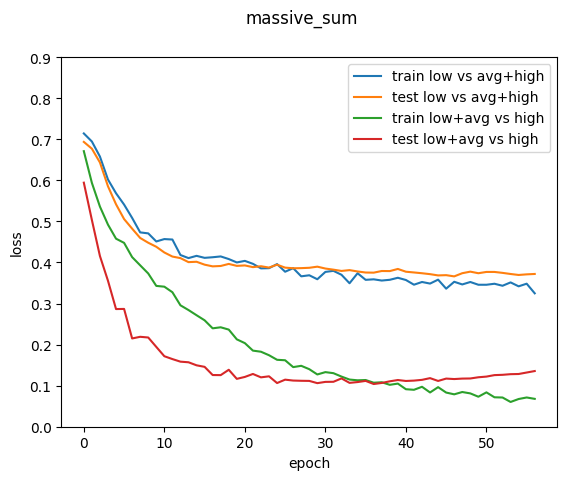

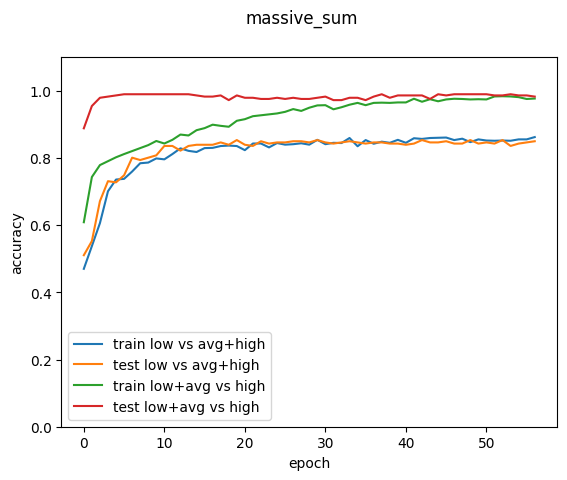

Average fraction of mistakes: massive_sum 0.16433566433566432


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

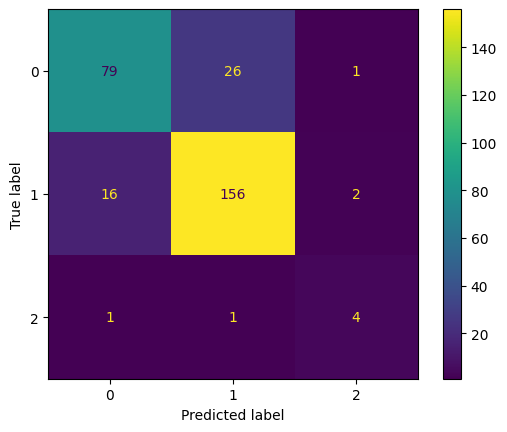

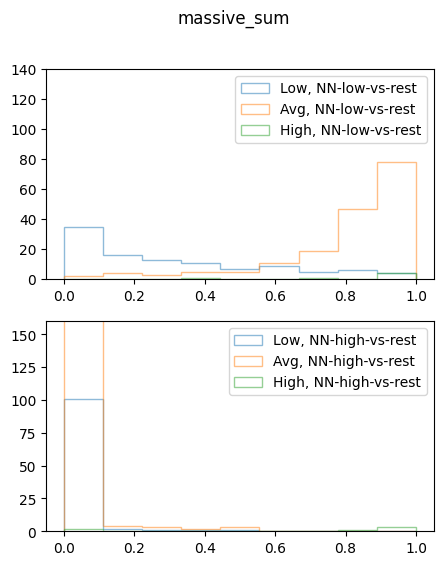

In [81]:
configs = {
    'simple':[
        {'simple':True},
        {},
    ],
    'base':[
        {},
        {},
    ],
    'dropout':[
        {'dropout':True},
        {},
    ],
    'long':[
        {},
        {'epochs':100},
    ],
    'massive':[
        {'dropout':True, 'deep':True},
        {'epochs':200},
    ],
    'massive_l2':[
        {'deep':True, 'kernel_regularizer':'l2'},
        {'epochs':100},
    ],
    'massive_l1':[
        {'deep':True, 'kernel_regularizer':'l1'},
        {'epochs':100},
    ],
}
configs['massive_sum'] = configs['massive']
configs['massive_no_cat'] = configs['massive']
configs['massive_with_id'] = configs['massive']

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df = resample_high(train_df,20)

train_y = get_labels(train_df)
test_y  = get_labels(test_df)

#histories = {}

def run_all(name):
    model_kwargs, run_kwargs = configs[name]
    model = get_model(name, df_resampled, **model_kwargs)
    
    history = train_model(name, model, dict(train_df), train_y, 
                      validation_data=(dict(test_df), test_y),
                      **run_kwargs
                     )
    histories[name] = (history, model)
    
    validation_plots(name, history, model, test_df)

#run_all('simple')
#run_all('base')
#run_all('dropout')
#run_all('long')
#run_all('massive')
run_all('massive_no_cat')
run_all('massive_sum')
#run_all('massive_l1')
#run_all('massive_l2')
#run_all('massive_with_id')


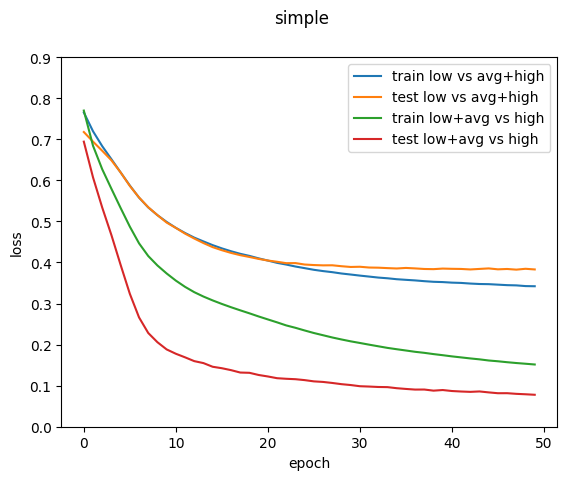

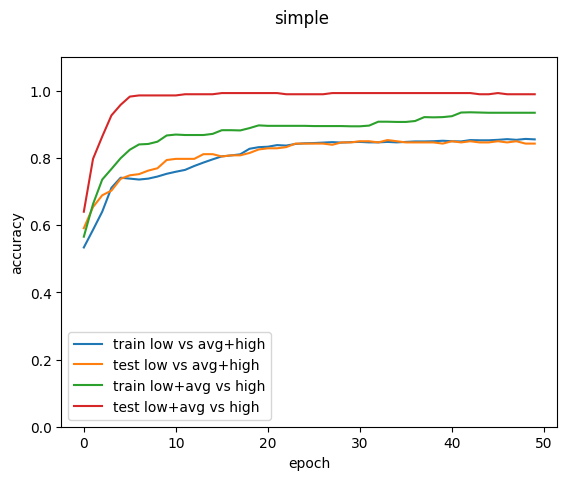

Average fraction of mistakes: simple 0.16783216783216784
Average fraction of sure decisions: simple 0.6678321678321678
Average fraction of mistakes on sure decisions: simple 0.08900523560209424


<Figure size 640x480 with 0 Axes>

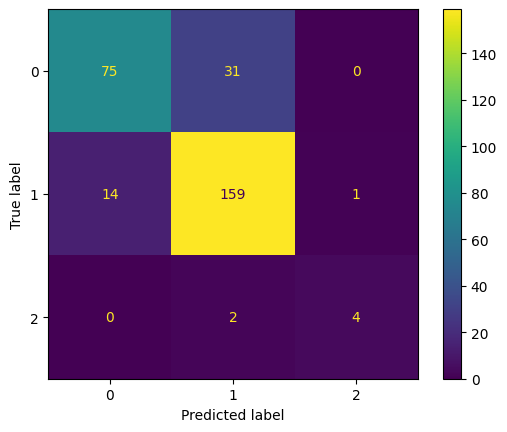

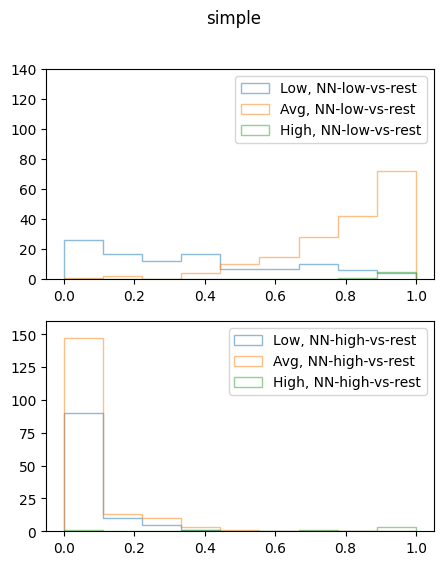

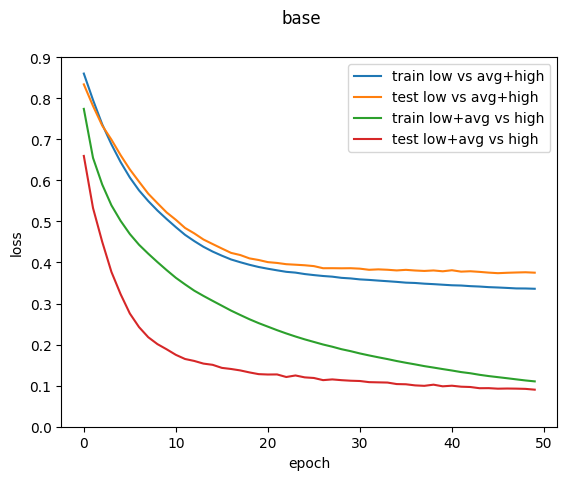

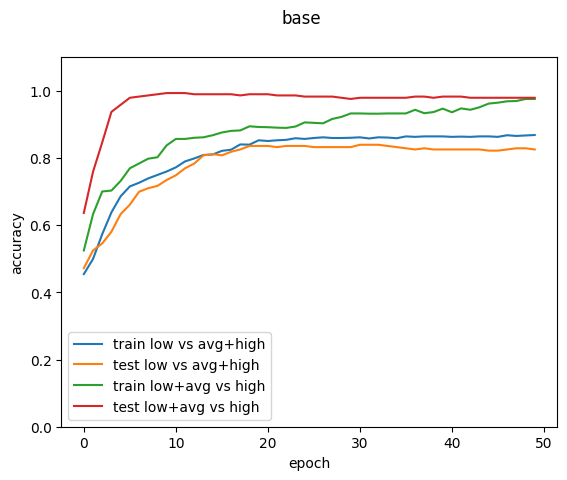

Average fraction of mistakes: base 0.19230769230769232
Average fraction of sure decisions: base 0.6433566433566433
Average fraction of mistakes on sure decisions: base 0.09239130434782608


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

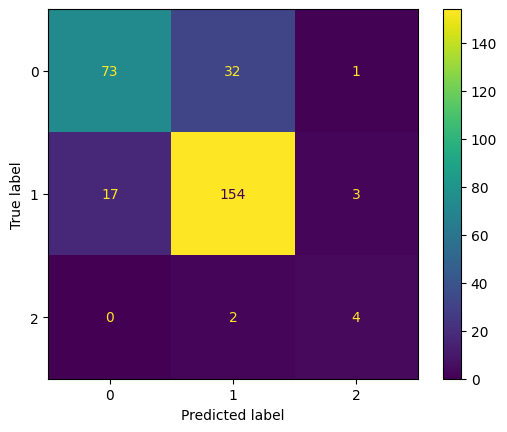

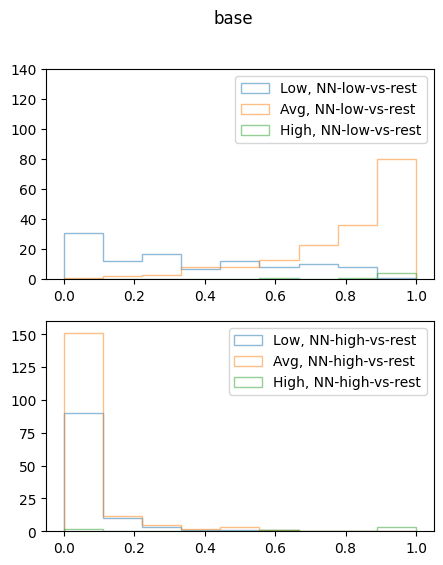

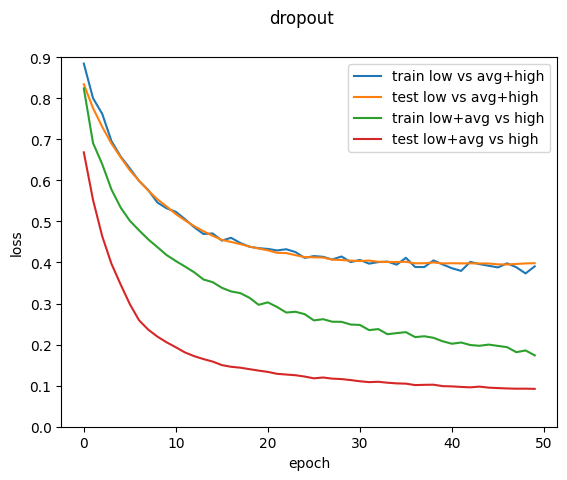

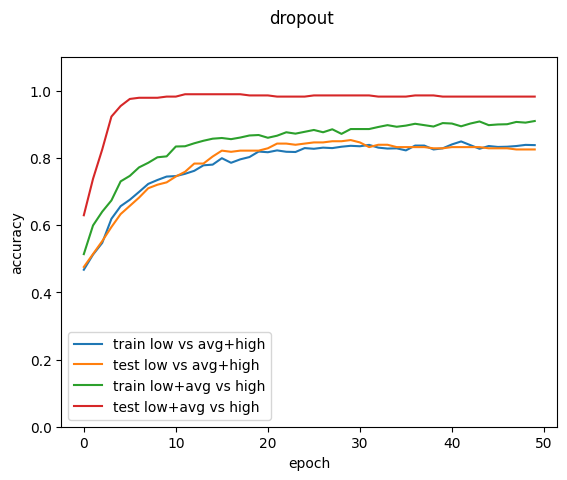

Average fraction of mistakes: dropout 0.1888111888111888
Average fraction of sure decisions: dropout 0.6048951048951049
Average fraction of mistakes on sure decisions: dropout 0.08670520231213873


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

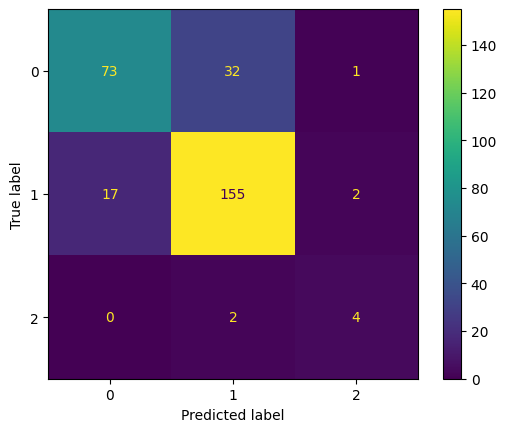

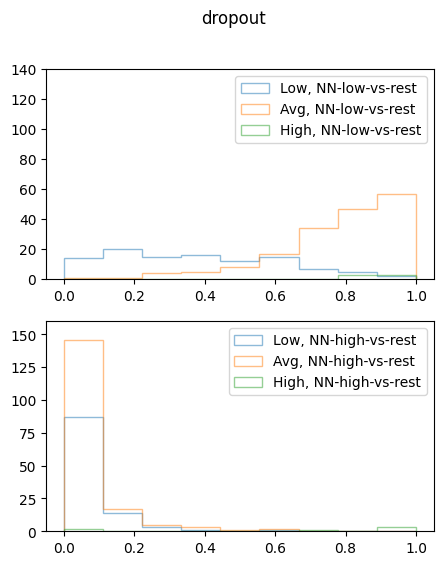

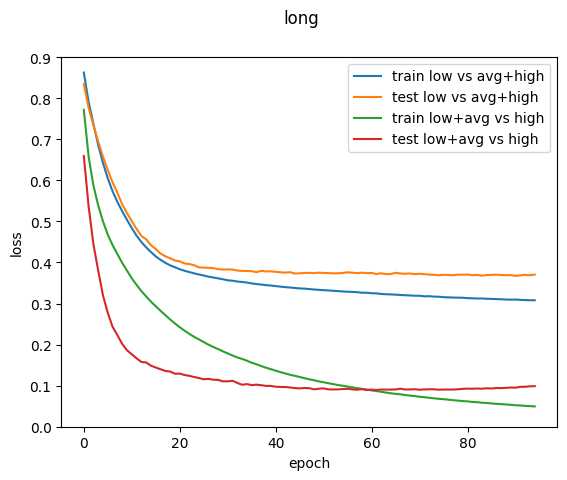

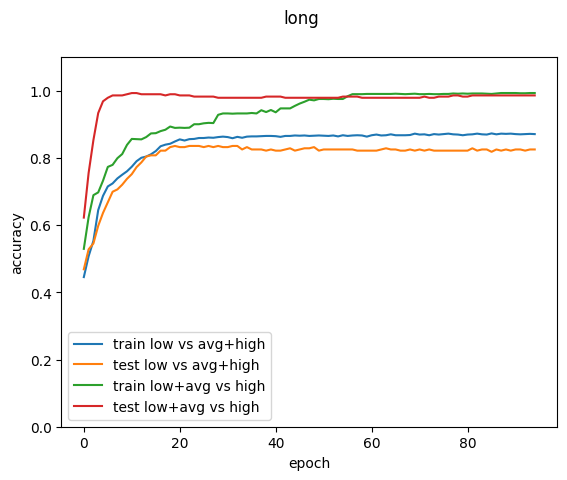

Average fraction of mistakes: long 0.1888111888111888
Average fraction of sure decisions: long 0.7097902097902098
Average fraction of mistakes on sure decisions: long 0.09852216748768473


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

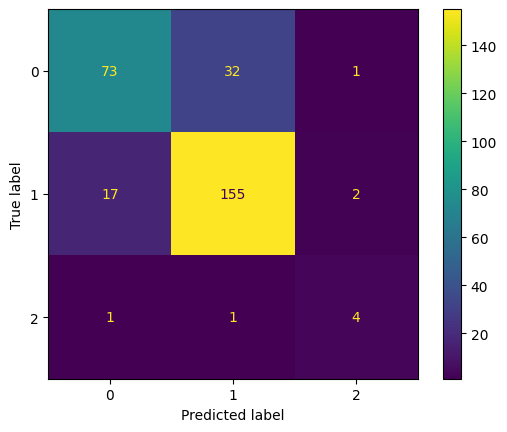

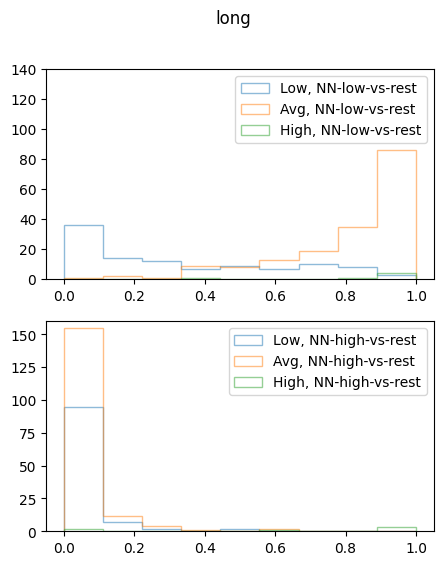

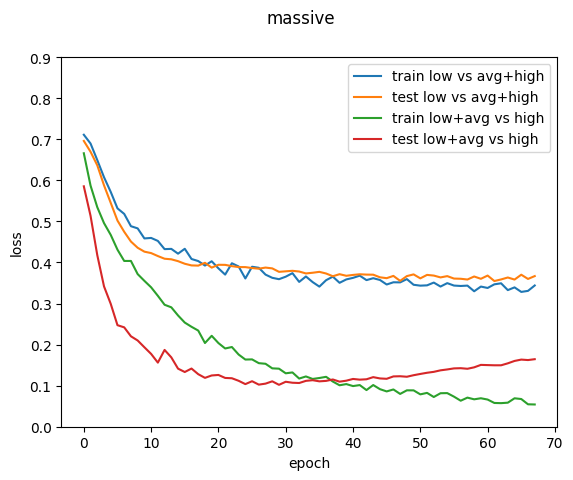

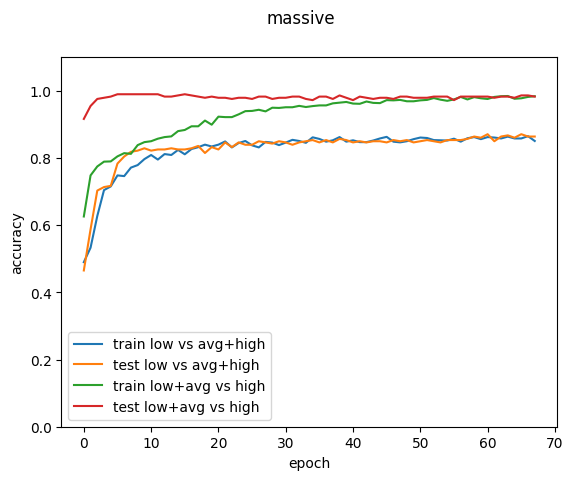

Average fraction of mistakes: massive 0.16083916083916083
Average fraction of sure decisions: massive 0.7132867132867133
Average fraction of mistakes on sure decisions: massive 0.08333333333333333


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

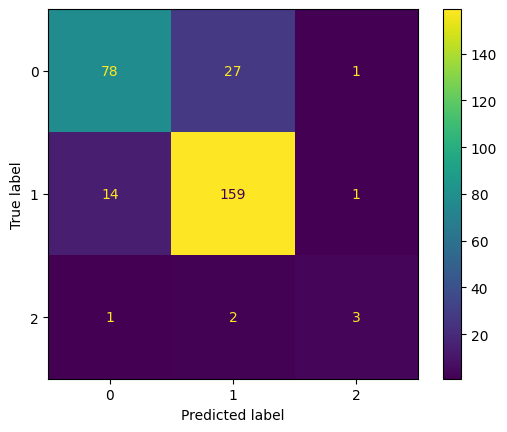

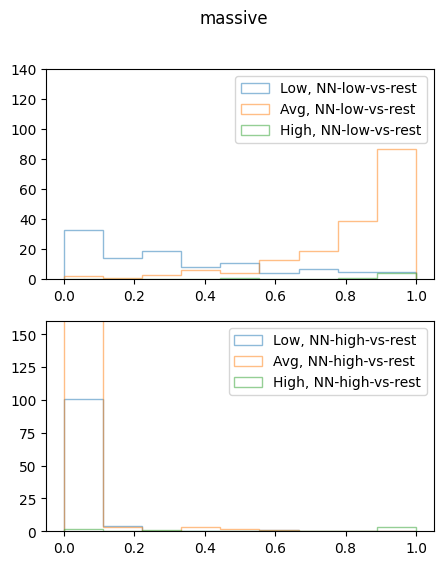

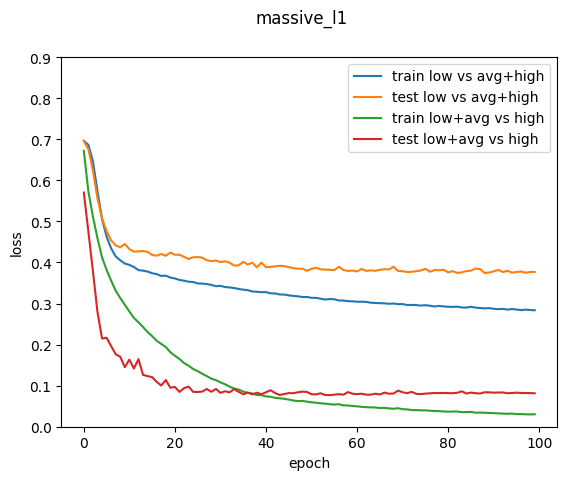

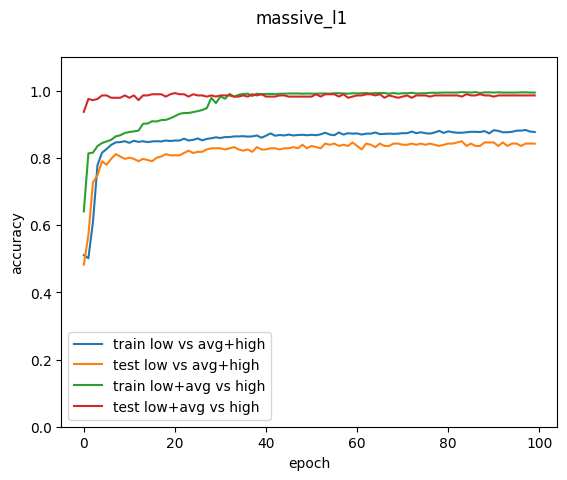

Average fraction of mistakes: massive_l1 0.16783216783216784
Average fraction of sure decisions: massive_l1 0.7517482517482518
Average fraction of mistakes on sure decisions: massive_l1 0.11162790697674418


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

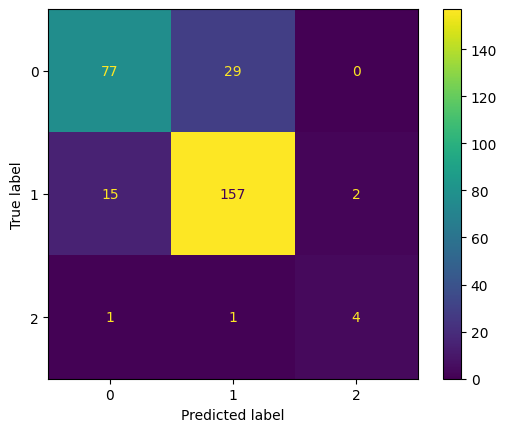

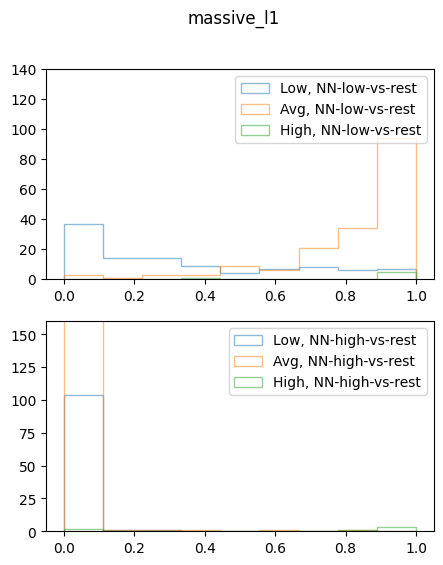

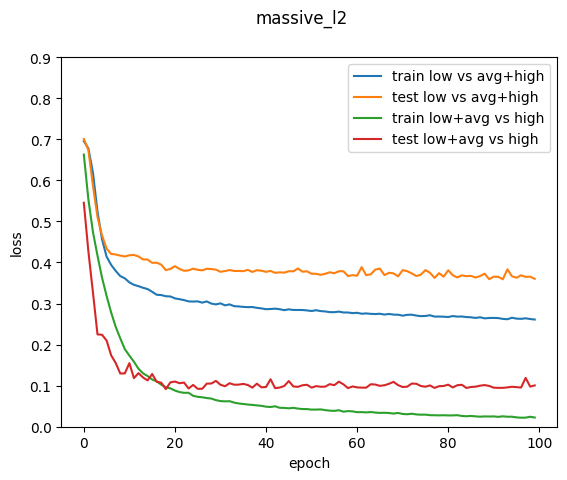

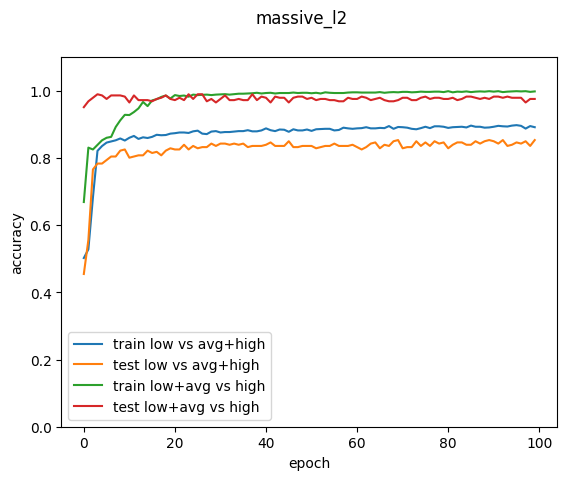

Average fraction of mistakes: massive_l2 0.16783216783216784
Average fraction of sure decisions: massive_l2 0.7797202797202797
Average fraction of mistakes on sure decisions: massive_l2 0.11210762331838565


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

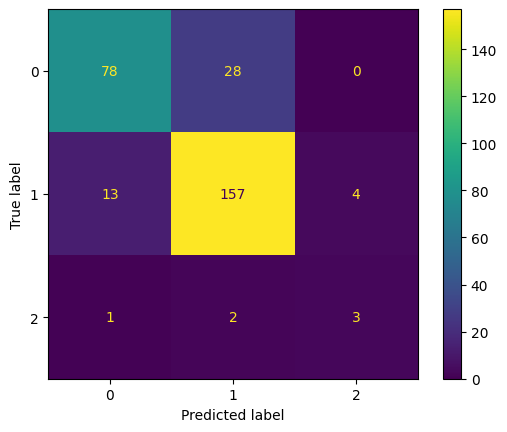

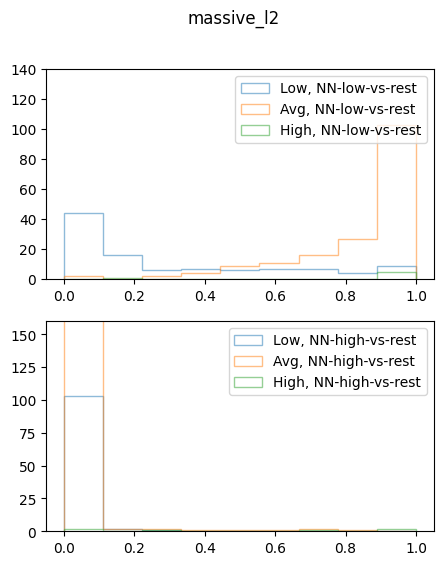

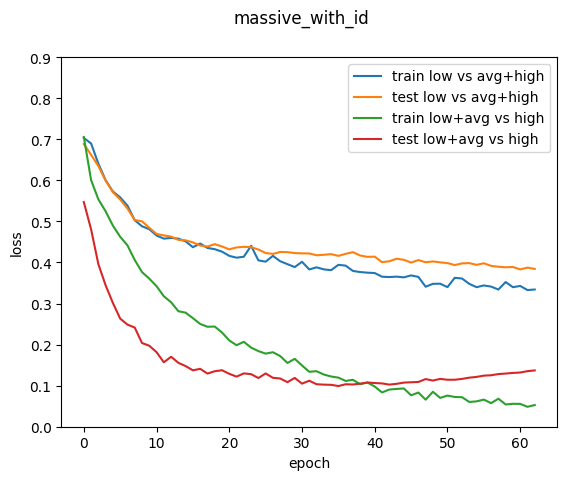

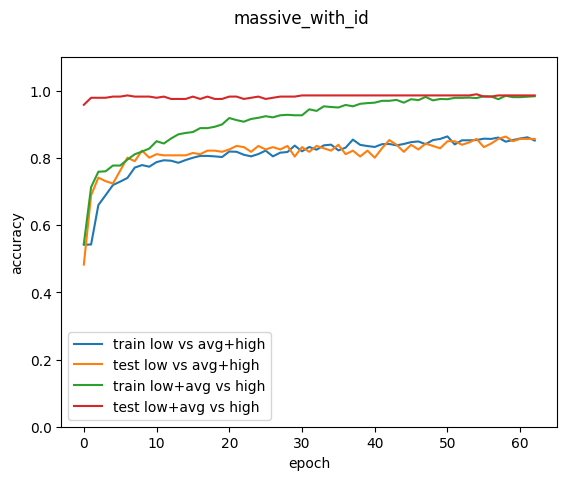

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Average fraction of mistakes: massive_with_id 0.15734265734265734
Average fraction of sure decisions: massive_with_id 0.6048951048951049
Average fraction of mistakes on sure decisions: massive_with_id 0.09248554913294797


<Figure size 640x480 with 0 Axes>

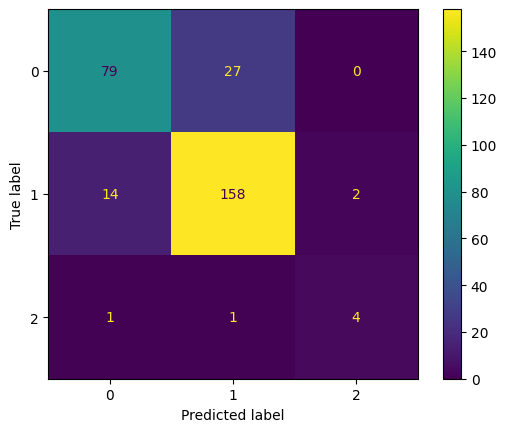

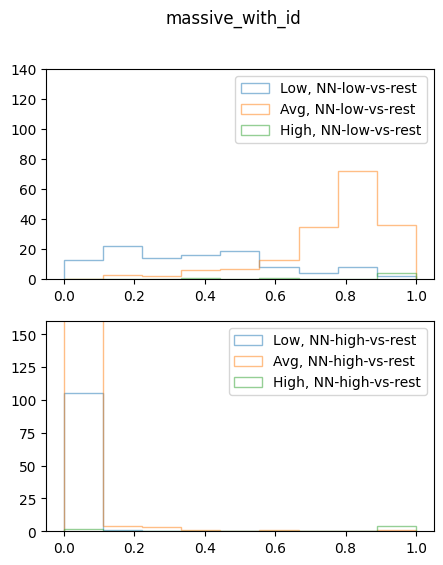

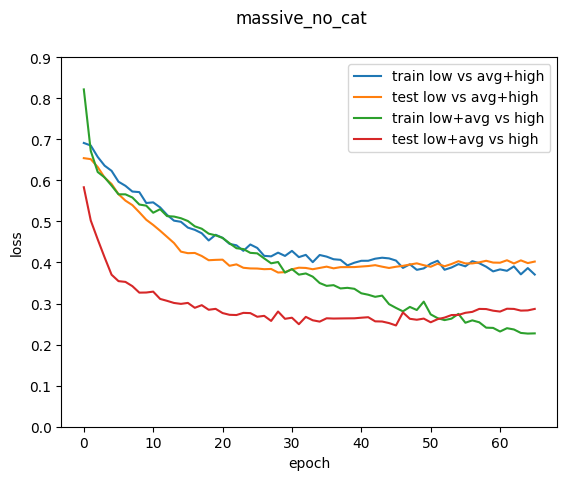

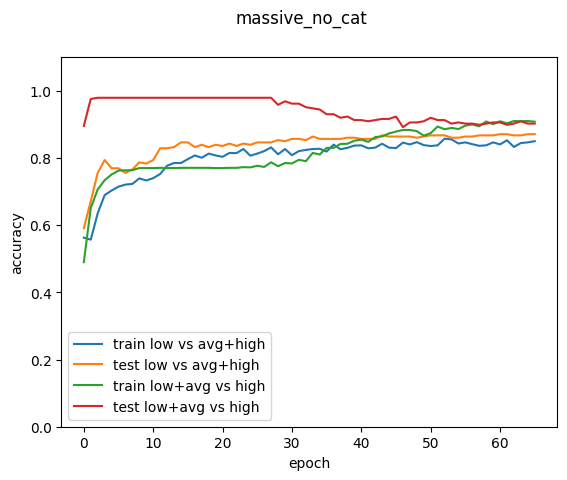

Average fraction of mistakes: massive_no_cat 0.1993006993006993
Average fraction of sure decisions: massive_no_cat 0.7377622377622378
Average fraction of mistakes on sure decisions: massive_no_cat 0.1848341232227488


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Production Recipe', 'Production Mill', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

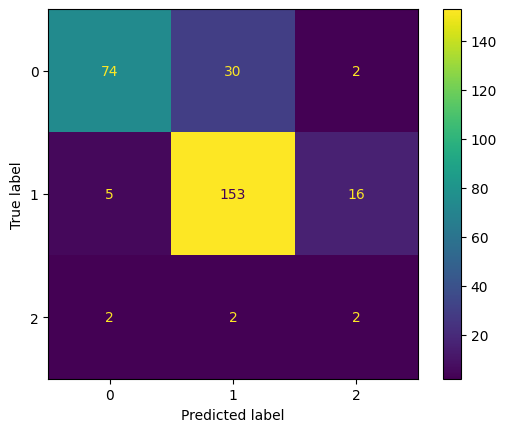

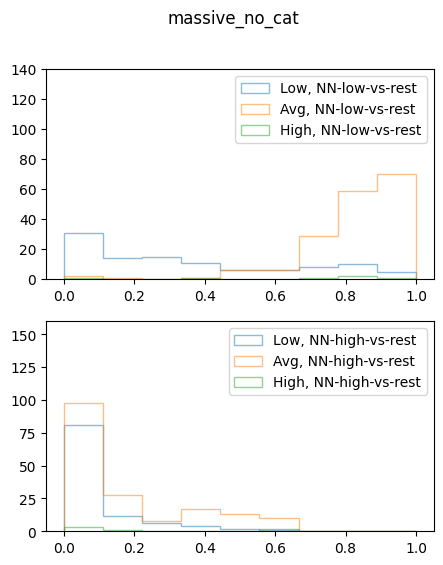

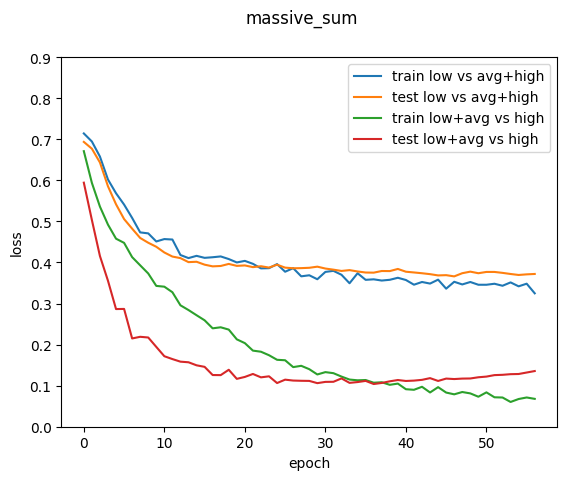

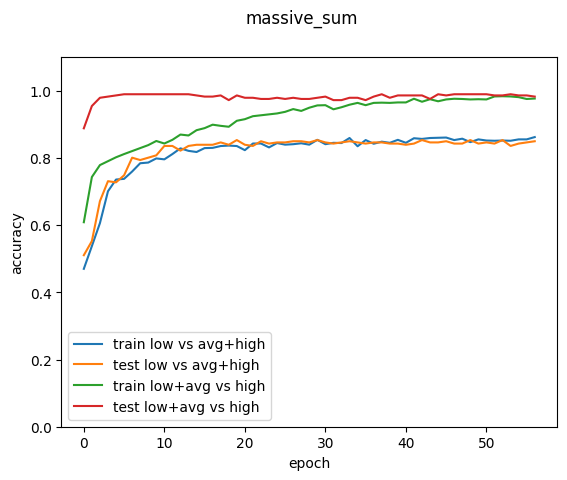

Average fraction of mistakes: massive_sum 0.16433566433566432
Average fraction of sure decisions: massive_sum 0.7237762237762237
Average fraction of mistakes on sure decisions: massive_sum 0.1111111111111111


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

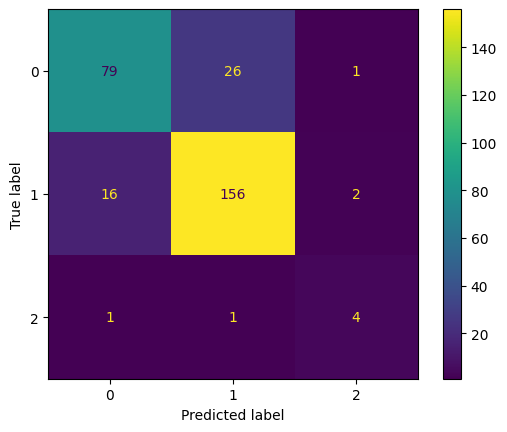

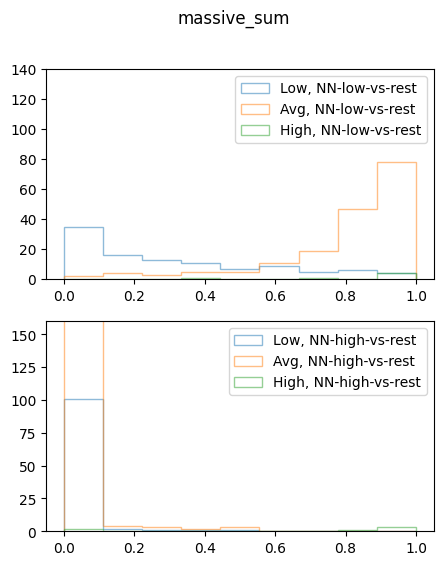

In [91]:
for name, (history, model) in histories.items():
    validation_plots(name, history, model, test_df)